In [1]:
import pandas as pd
import requests
from datetime import datetime
import time

def get_historical_klines(symbol, interval, start_date, end_date=None):
    """
    Get historical klines from Binance API and return only the essential data points
    
    Parameters:
    symbol (str): Trading pair symbol (e.g., 'BTCUSDT')
    interval (str): Candlestick interval (e.g., '1h')
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format, if None, current time is used
    
    Returns:
    pd.DataFrame: DataFrame with timestamp, open, high, low, close, volume
    """
    # Binance API endpoint for klines
    endpoint = 'https://api.binance.com/api/v3/klines'
    
    # Convert dates to timestamps
    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    
    if end_date:
        end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
    else:
        end_timestamp = int(datetime.now().timestamp() * 1000)
    
    # Binance has a limit of 1000 candles per request
    all_klines = []
    current_timestamp = start_timestamp
    
    print(f"Downloading {symbol} {interval} data from {start_date} to {end_date or 'now'}...")
    
    while current_timestamp < end_timestamp:
        # Parameters for the API request
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_timestamp,
            'endTime': end_timestamp,
            'limit': 1000  # maximum allowed by Binance
        }
        
        # Make the API request
        response = requests.get(endpoint, params=params)
        
        # Check if request was successful
        if response.status_code == 200:
            klines = response.json()
            
            if not klines:
                break
                
            all_klines.extend(klines)
            
            # Update current_timestamp to get the next batch
            current_timestamp = klines[-1][0] + 1
            
            # Sleep to avoid hitting rate limits
            time.sleep(0.5)
            
            # Print progress
            current_date = datetime.fromtimestamp(klines[-1][0]/1000).strftime('%Y-%m-%d')
            print(f"Downloaded data up to: {current_date}")
        else:
            print(f"Error fetching data: {response.status_code}")
            print(f"Response: {response.text}")
            break
    
    # If we got some data, convert it to DataFrame
    if all_klines:
        # Extract only the columns we need
        simplified_klines = []
        for k in all_klines:
            simplified_klines.append([
                k[0],  # timestamp
                k[1],  # open
                k[2],  # high
                k[3],  # low
                k[4],  # close
                k[5],  # volume
            ])
        
        # Create DataFrame with only the columns we need
        df = pd.DataFrame(simplified_klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume'
        ])
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        
        # Convert numeric columns to float
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = df[col].astype(float)
        
        return df
    
    return pd.DataFrame()

def save_historical_data(symbol, interval, start_date, end_date=None):
    """
    Save historical data to a CSV file
    """
    df = get_historical_klines(symbol, interval, start_date, end_date)
    
    if df.empty:
        print("No data retrieved.")
        return
    
    filename = f"{symbol}_{interval}_{start_date.replace('-', '')}_to_{end_date.replace('-', '') if end_date else 'now'}.csv"
    df.to_csv(filename, index=False)
    
    print(f"\nData saved to {filename}")
    print(f"Retrieved {len(df)} candles")
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Example usage
if __name__ == "__main__":
    # Symbol and interval
    symbol = "BTCUSDT"
    interval = "1h"
    
    # Starting from the earliest data available on Binance (July 2017)
    start_date = "2017-07-01"
    
    # Current date as end date (or specify a custom end date)
    end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Save data to CSV
    save_historical_data(symbol, interval, start_date, end_date)

Downloaded data up to: 2017-09-28
Downloaded data up to: 2017-11-08
Downloaded data up to: 2017-12-20
Downloaded data up to: 2018-01-31
Downloaded data up to: 2018-03-15
Downloaded data up to: 2018-04-26
Downloaded data up to: 2018-06-06
Downloaded data up to: 2018-07-19
Downloaded data up to: 2018-08-29
Downloaded data up to: 2018-10-10
Downloaded data up to: 2018-11-21
Downloaded data up to: 2019-01-02
Downloaded data up to: 2019-02-12
Downloaded data up to: 2019-03-26
Downloaded data up to: 2019-05-07
Downloaded data up to: 2019-06-18
Downloaded data up to: 2019-07-30
Downloaded data up to: 2019-09-10
Downloaded data up to: 2019-10-21
Downloaded data up to: 2019-12-02
Downloaded data up to: 2020-01-13
Downloaded data up to: 2020-02-24
Downloaded data up to: 2020-04-05
Downloaded data up to: 2020-05-17
Downloaded data up to: 2020-06-28
Downloaded data up to: 2020-08-09
Downloaded data up to: 2020-09-19
Downloaded data up to: 2020-10-31
Downloaded data up to: 2020-12-12
Downloaded dat

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
import ta  # Technical Analysis library

In [27]:
# 1. Load and prepare the data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    return df

In [29]:
# 2. Feature engineering - add technical indicators
def add_technical_indicators(df):
    # Add moving averages
    df['MA7'] = df['close'].rolling(window=7).mean()
    df['MA14'] = df['close'].rolling(window=14).mean()
    df['MA30'] = df['close'].rolling(window=30).mean()
    
    # Add RSI
    df['RSI'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    
    # Add MACD
    macd = ta.trend.MACD(df['close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    
    # Add Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['close'])
    df['BB_high'] = bollinger.bollinger_hband()
    df['BB_low'] = bollinger.bollinger_lband()
    
    # Add volatility measure
    df['volatility'] = df['close'].pct_change().rolling(window=14).std()
    
    # Add price momentum
    df['pct_change'] = df['close'].pct_change()
    df['pct_change_3'] = df['close'].pct_change(periods=3)
    df['pct_change_7'] = df['close'].pct_change(periods=7)
    
    # Drop rows with NaN values (created by rolling windows)
    df.dropna(inplace=True)
    
    return df

In [31]:
# 3. Prepare data for LSTM
def prepare_lstm_data(df, target_col='close', window_size=24, forecast_horizon=1):
    """
    Prepare data for LSTM model with a specified window size and forecast horizon
    window_size: Number of past time steps to use as input features
    forecast_horizon: How many steps ahead to predict
    """
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    
    X, y = [], []
    for i in range(window_size, len(scaled_data) - forecast_horizon + 1):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i + forecast_horizon - 1, df.columns.get_loc(target_col)])  # Target is the close price
    
    X, y = np.array(X), np.array(y)
    
    # Determine the split point (e.g., 80% train, 20% test)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test, scaler, df.columns.get_loc(target_col)

In [33]:
def build_lstm_model(input_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [55]:
def train_lightgbm(df, target_col='close', window_size=24, forecast_horizon=1):
    """Train a LightGBM model for comparison and feature importance analysis"""
    # Create features and target
    features = []
    target = []
    
    # For each time step, use past window_size values of all features to predict future close price
    for i in range(window_size, len(df) - forecast_horizon + 1):
        # Flatten past window_size rows into a single feature vector
        row_features = df.iloc[i-window_size:i].values.flatten()
        features.append(row_features)
        target.append(df.iloc[i + forecast_horizon - 1][target_col])
    
    features = np.array(features)
    target = np.array(target)
    
    # Split the data
    split_idx = int(len(features) * 0.8)
    X_train, X_test = features[:split_idx], features[split_idx:]
    y_train, y_test = target[:split_idx], target[split_idx:]
    
    # Train the model
    train_data = lgb.Dataset(X_train, label=y_train)
    validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'verbose': -1
    }
    
    # Fixed parameter name: early_stopping_rounds → early_stopping_round
    model = lgb.train(
        params,
        train_data,
        valid_sets=[validation_data],
        num_boost_round=1000)
    
    return model, X_test, y_test

In [57]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

In [59]:
# 7. Create a simple ensemble of models
def ensemble_predictions(lstm_pred, lgbm_pred, weights=[0.7, 0.3]):
    """Create a weighted average of predictions"""
    return weights[0] * lstm_pred + weights[1] * lgbm_pred

In [61]:
# 8. Real-time prediction function using the trained models
def predict_next_price(lstm_model, lgbm_model, latest_data, window_size, scaler, target_idx):
    """
    Make a prediction for the next time period using the latest data
    """
    # Scale the latest data
    scaled_data = scaler.transform(latest_data.iloc[-window_size:])
    
    # Prepare data for LSTM
    lstm_input = scaled_data.reshape(1, window_size, scaled_data.shape[1])
    
    # Get LSTM prediction
    lstm_pred = lstm_model.predict(lstm_input)
    
    # Prepare data for LightGBM
    lgbm_input = scaled_data.flatten().reshape(1, -1)
    
    # Get LightGBM prediction
    lgbm_pred = lgbm_model.predict(lgbm_input)
    
    # Create ensemble prediction (weighted average)
    ensemble_pred = ensemble_predictions(lstm_pred[0][0], lgbm_pred[0], weights=[0.7, 0.3])
    
    # Create dummy array for inverse transform
    dummy = np.zeros((1, scaled_data.shape[1]))
    dummy[0, target_idx] = ensemble_pred
    
    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(dummy)[0, target_idx]
    
    return predicted_price

Data shape after adding indicators: (65782, 17)


C:\Users\Aakash\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - loss: 0.0015 - val_loss: 3.9355e-05
Epoch 2/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 2.7960e-04 - val_loss: 1.2495e-05
Epoch 3/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 2.4043e-04 - val_loss: 1.6880e-05
Epoch 4/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - loss: 2.2741e-04 - val_loss: 4.8040e-05
Epoch 5/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 2.3614e-04 - val_loss: 1.3836e-05
Epoch 6/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 2.0667e-04 - val_loss: 9.5516e-06
Epoch 7/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 2.0945e-04 - val_loss: 1.9959e-05
Epoch 8/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.9712e-04 - val_loss: 1.1525e-05
Epoch 9/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.9845e-04 - val_loss: 2.8369e-05
Epoch 10/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 1.9473e-04 - val_loss: 1.0736e-05
Epoch 11/100


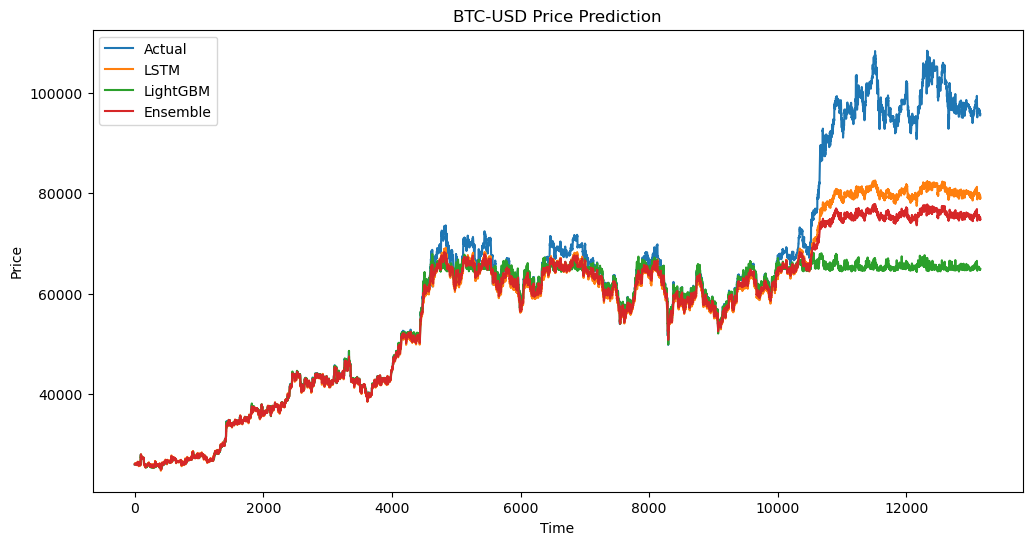

Models trained and saved successfully


In [63]:
def main():
    # Load data
    file_path = "C:/Users/Aakash/BTCUSDT_1h_20170701_to_20250224.csv"  # Update with your actual file path
    df = load_data(file_path)
    
    # Add technical indicators
    df = add_technical_indicators(df)
    print(f"Data shape after adding indicators: {df.shape}")
    
    # Prepare data for LSTM
    window_size = 24  # Use 24 hours of data to predict
    forecast_horizon = 1  # Predict 1 hour ahead
    X_train, X_test, y_train, y_test, scaler, target_idx = prepare_lstm_data(
        df, target_col='close', window_size=window_size, forecast_horizon=forecast_horizon
    )
    
    # Build and train LSTM model
    lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = lstm_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions with LSTM
    lstm_predictions = lstm_model.predict(X_test)
    
    # Prepare for inverse scaling
    dummy = np.zeros((len(lstm_predictions), X_test.shape[2]))
    dummy[:, target_idx] = lstm_predictions.flatten()
    
    # Inverse transform
    lstm_predictions_actual = scaler.inverse_transform(dummy)[:, target_idx]
    
    # Prepare actual values for comparison
    dummy_actual = np.zeros((len(y_test), X_test.shape[2]))
    dummy_actual[:, target_idx] = y_test
    actual_values = scaler.inverse_transform(dummy_actual)[:, target_idx]
    
    # Train LightGBM model
    lgbm_model, X_lgbm_test, y_lgbm_test = train_lightgbm(
        df, target_col='close', window_size=window_size, forecast_horizon=forecast_horizon
    )
    
    # Make predictions with LightGBM
    lgbm_predictions = lgbm_model.predict(X_lgbm_test)
    
    # Create ensemble predictions
    ensemble_predictions = [
        lstm_predictions_actual[i] * 0.7 + lgbm_predictions[i] * 0.3
        for i in range(len(lstm_predictions_actual))
    ]
    
    # Evaluate models
    evaluate_model(actual_values, lstm_predictions_actual, "LSTM")
    evaluate_model(y_lgbm_test, lgbm_predictions, "LightGBM")
    evaluate_model(actual_values, ensemble_predictions, "Ensemble")
    
    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual')
    plt.plot(lstm_predictions_actual, label='LSTM')
    plt.plot(lgbm_predictions, label='LightGBM')
    plt.plot(ensemble_predictions, label='Ensemble')
    plt.title('BTC-USD Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig('prediction_results.png')
    plt.show()
    
    # Save models for real-time prediction
    lstm_model.save('lstm_model.h5')
    lgbm_model.save_model('lgbm_model.txt')
    
    print("Models trained and saved successfully")

if __name__ == "__main__":
    main()